<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<span>
<h2>Eliminación de ruido en imágenes de resonancia magnética, mediante red neuronal convolucional CNN </h2> 
</span>

<span>
<h3>Selección de modelo pre-entrenado para Red neuronal convolucional CNN </h3> 
</span>

El aprendizaje por transferencia es extremadamente popular en el aprendizaje profundo, ya que la "transferencia" de conocimiento de un modelo "principal" a un modelo "secundario" significa que el modelo "secundario" puede entrenarse con gran precisión con un conjunto de datos mucho más pequeño en comparación con el modelo "principal". "

Los marcos de aprendizaje profundo de alto nivel como TensorFlow y Pytorch han hecho que sea increíblemente fácil aprovechar el poder del aprendizaje de transferencia al incluir varios modelos pre-entrenados dentro del paquete mismo. Por ejemplo, la API de TensorFlow Keras incluye 18 arquitecturas de modelos altamente avanzadas entrenadas previamente en el conjunto de datos "ImageNet" . Puede pensar en "ImageNet" como el SAT de conjuntos de datos de clasificación de imágenes.

<b>Criterios para la selección de modelos.</b>
<p>En general, hay dos criterios en competencia al realizar cualquier tarea de aprendizaje automático en la industria:</p>

- Precisión del modelo: Más alto Mejor
- Velocidad de entrenamiento y predicciones de modelos: más rápido, mejor

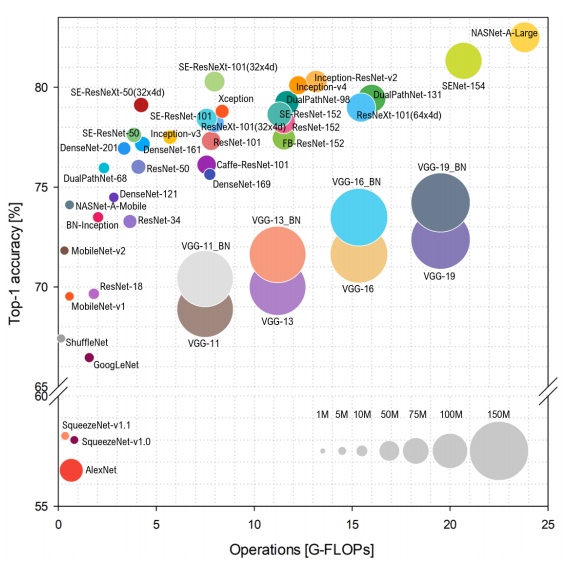



<p style="text-align:center;">Fuente: <a href="https://arxiv.org/pdf/1810.00736.pdf">https://arxiv.org/pdf/1810.00736.pdf <a/></p>

<b>Pasos para seleccionar los modelos a entrenar:</b>
    
1. Importar paquetes requeridos.
2. Listar todos los modelos de Keras y Tensorflow.
3. Preparar los conjuntos de datos de Entrenamiento, pruebas y validación.
4. Iterar cada modelo calculando la presición, la validación de la presición y el tamaño del modelo.
5. Analizar y visualizar los resultados para seleccionar el modelo.

## Instalar librerías

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
!pip install pandas

In [49]:
!pip install tqdm

## Paso 1. Importar librerías

In [65]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

batch_size = 32

## Paso 2. Obtener lista de modelo pre-entrenados

In [64]:
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
model_dictionary

{'DenseNet121': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'DenseNet169': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'DenseNet201': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'InceptionResNetV2': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'InceptionV3': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'MobileNet': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'MobileNetV2': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'NASNetLarge': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'NASNetMobi

In [63]:
import itertools
#model_dictionary = dict(itertools.islice(model_dictionary.items(), 14 , 18))
#model_dictionary = dict(itertools.islice(model_dictionary.items(), 1 , 18))
print(model_dictionary)

dict_items([])


## Paso 3. Preparar los conjuntos de datos de entrenamiento, pruebas y validación.

Preprocesar las imágenes de entrada. Algunos modelos pre-entrenados requieren que las imágenes tengan un tamaño (224,224,3), mientras que otros requieren (331,331,3). Usamos este paso para preparar ambos tamaños de imágenes y normalizarlos dividiendo cada píxel por 255. También codificamos las etiquetas en  para que podamos usar la categorical_loss_crossentropy durante el entrenamiento.

In [66]:
# Entrenamiento 
path_train = 'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/ENTRENAMIENTO/' 

# Validación 
path_val = 'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/VALIDACION/' 

In [67]:
def normalize_img(image, ):
    # Imagen normalizada
    image = tf.cast(image, tf.float32) / 255.    
    return image

In [68]:
dim = (331,331)


# Entrenamiento 331 x 331
train_processed_331 = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory=path_train,
                         target_size=dim, 
                         classes=['AD','CN','MCI'],
                         batch_size=batch_size)
    
# Validación 331 x 331
validation_processed_331 = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory=path_val,
                         target_size=dim,
                         classes=['AD','CN','MCI'],
                         batch_size=batch_size)

Found 5343 images belonging to 3 classes.
Found 1265 images belonging to 3 classes.


In [69]:
dim = (224,224)

# Entrenamiento 224 x 224
train_processed_224 = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory=path_train, 
                         target_size=dim, 
                         classes=['AD','CN','MCI'], 
                         batch_size=batch_size)
   
# Validación
validation_processed_224 = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory=path_val, 
                         target_size=dim,
                         classes=['AD','CN','MCI'],
                         batch_size=batch_size)

Found 5343 images belonging to 3 classes.
Found 1265 images belonging to 3 classes.


In [70]:
imgs, labels = next(train_processed_224)

In [71]:
imgs[0].shape

(224, 224, 3)

## Paso 4. Iterar cada modelo calculando la presición, la validación de la precisión y el tamaño del modelo.

Recorremos cada modelo descargando el modelo pre-entrenado sin las capas de salida y congelando las capas de entrenamiento. Luego construimos un modelo vacío Sequential, primero le agregamos el modelo previamente entrenado. Luego agregamos una sola capa densa de salida con la función de activación softmaxa y la compilamos con categorical_loss_crossentropy. Finalmente, entrenamos el modelo llamando model.fita 3 epochs.

In [72]:
# Bucle sobre cada modelo disponible en Keras

num_classes = train_processed_224.num_classes
num_iterations = int(validation_processed_224.n/batch_size)
print(validation_processed_224.n)
print(batch_size)
print(num_iterations)

for model_name, model in tqdm(model_dictionary.items()):
    
    print(model_name)
    
    # Manejo especial para "NASNetLarge" ya que requiere imágenes de entrada con tamaño (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_processed_331
        validation_processed = validation_processed_331
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224

    # cargar el modelo pre-entrenado con agrupación promedio global como la última capa y congelar los pesos del modelo
    pre_trained_model = model(include_top=False,
                              pooling='avg',
                              input_shape=input_shape)
    pre_trained_model.trainable = False

    # modificaciones personalizadas sobre el modelo pre-entrenado
    with tf.device('DML'):
        clf_model = tf.keras.models.Sequential()
        clf_model.add(pre_trained_model)
        clf_model.add(tf.keras.layers.Dense(num_classes,
                                            activation='softmax'))
        clf_model.compile(loss='categorical_crossentropy',
                          metrics=['accuracy'])
    
   
        history = clf_model.fit(train_processed,
                                epochs=3,
                                validation_data=validation_processed,
                                steps_per_epoch = num_iterations
                               )

        # Almacenar todas las métricas relevantes
        
        path_metricas = r'D:/TFM/Notebooks/ELT/Recursos/metricas_modelos_keras.csv'
        with open(path_metricas, 'a', newline='') as csvfile:
            fieldnames = ['model_name', 'num_model_params', 'accuracy', 'validation_accuracy', 'loss', 'val_loss']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writerow({
                                'model_name':str(model_name),
                                'num_model_params': str(pre_trained_model.count_params()),
                                'accuracy':str(history.history['acc'][-1]),
                                'validation_accuracy': str(history.history['val_acc'][-1]),
                                'loss': str(history.history['loss'][-1]),
                                'val_loss': str(history.history['val_loss'][-1])
                            })

       

1265
32
39


  0%|                                                                                              | 0/18 [00:00<?, ?it/s]

DenseNet121
Epoch 1/3
39/39 [==============================] - 40s 1s/step - loss: 1.2062 - acc: 0.3766 - val_loss: 1.2592 - val_acc: 0.3455
Epoch 2/3
39/39 [==============================] - 23s 601ms/step - loss: 1.1619 - acc: 0.3934 - val_loss: 1.3744 - val_acc: 0.3415
Epoch 3/3
39/39 [==============================] - 23s 594ms/step - loss: 1.0950 - acc: 0.4383 - val_loss: 1.3103 - val_acc: 0.3439


  6%|████▋                                                                                | 1/18 [01:58<33:28, 118.17s/it]

DenseNet169
Epoch 1/3
39/39 [==============================] - 53s 1s/step - loss: 1.2462 - acc: 0.3392 - val_loss: 1.2177 - val_acc: 0.3470
Epoch 2/3
39/39 [==============================] - 29s 739ms/step - loss: 1.1372 - acc: 0.3742 - val_loss: 1.4758 - val_acc: 0.3375
Epoch 3/3
39/39 [==============================] - 28s 728ms/step - loss: 1.0652 - acc: 0.4495 - val_loss: 1.2405 - val_acc: 0.3549


 11%|█████████▍                                                                           | 2/18 [04:28<36:33, 137.07s/it]

DenseNet201
Epoch 1/3
39/39 [==============================] - 70s 2s/step - loss: 1.1985 - acc: 0.3542 - val_loss: 1.1685 - val_acc: 0.3470
Epoch 2/3
39/39 [==============================] - 36s 931ms/step - loss: 1.1148 - acc: 0.4183 - val_loss: 1.2764 - val_acc: 0.3676
Epoch 3/3
39/39 [==============================] - 36s 928ms/step - loss: 1.0505 - acc: 0.4571 - val_loss: 1.2515 - val_acc: 0.3652


 17%|██████████████▏                                                                      | 3/18 [07:45<41:05, 164.37s/it]

InceptionResNetV2
Epoch 1/3
39/39 [==============================] - 80s 2s/step - loss: 1.1272 - acc: 0.3753 - val_loss: 1.5207 - val_acc: 0.3447
Epoch 2/3
39/39 [==============================] - 33s 849ms/step - loss: 1.0832 - acc: 0.4143 - val_loss: 1.5640 - val_acc: 0.3549
Epoch 3/3
39/39 [==============================] - 34s 862ms/step - loss: 1.0766 - acc: 0.4159 - val_loss: 1.3710 - val_acc: 0.3834


 22%|██████████████████▉                                                                  | 4/18 [11:20<43:01, 184.41s/it]

InceptionV3
Epoch 1/3
39/39 [==============================] - 70s 2s/step - loss: 1.1987 - acc: 0.3553 - val_loss: 1.6392 - val_acc: 0.3217
Epoch 2/3
39/39 [==============================] - 25s 640ms/step - loss: 1.1509 - acc: 0.3934 - val_loss: 1.3786 - val_acc: 0.3439
Epoch 3/3
39/39 [==============================] - 25s 635ms/step - loss: 1.1234 - acc: 0.4071 - val_loss: 1.2118 - val_acc: 0.3225


 28%|███████████████████████▌                                                             | 5/18 [14:28<40:14, 185.76s/it]

MobileNet
Epoch 1/3
39/39 [==============================] - 68s 2s/step - loss: 1.2510 - acc: 0.3910 - val_loss: 1.3569 - val_acc: 0.3557
Epoch 2/3
39/39 [==============================] - 26s 667ms/step - loss: 1.1499 - acc: 0.4119 - val_loss: 1.6407 - val_acc: 0.3328
Epoch 3/3
39/39 [==============================] - 26s 670ms/step - loss: 1.0773 - acc: 0.4671 - val_loss: 1.6076 - val_acc: 0.3447


 33%|████████████████████████████▎                                                        | 6/18 [17:35<37:12, 186.01s/it]

MobileNetV2
Epoch 1/3
39/39 [==============================] - 76s 2s/step - loss: 1.2073 - acc: 0.3854 - val_loss: 1.1920 - val_acc: 0.3557
Epoch 2/3
39/39 [==============================] - 28s 726ms/step - loss: 1.1367 - acc: 0.4014 - val_loss: 1.2022 - val_acc: 0.3668
Epoch 3/3
39/39 [==============================] - 28s 709ms/step - loss: 1.0556 - acc: 0.4575 - val_loss: 1.2635 - val_acc: 0.3628


 39%|█████████████████████████████████                                                    | 7/18 [21:02<35:21, 192.90s/it]

NASNetLarge
Epoch 1/3


 39%|█████████████████████████████████                                                    | 7/18 [24:19<38:14, 208.55s/it]


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[32,96,171,171] and type float on /job:localhost/replica:0/task:0/device:DML:0 by allocator DmlAllocator
	 [[{{node NASNet/separable_conv_1_pad_reduction_right1_stem_1/Pad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_40/acc/Identity/_47251]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[32,96,171,171] and type float on /job:localhost/replica:0/task:0/device:DML:0 by allocator DmlAllocator
	 [[{{node NASNet/separable_conv_1_pad_reduction_right1_stem_1/Pad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

## Paso 5. Analizar y visualizar los resultados para seleccionar el modelo.

Nuestro objetivo es seleccionar el modelo más pequeño con la precisión suficiente. En este ejemplo, el MobileNetmodelo ya proporciona 97%precisión; por lo tanto, podemos usarlo directamente. MobileNetV2y NASNetMobile son otros dos modelos que podemos considerar para experimentos de ajuste fino. Si la precisión de nuestro modelo seleccionado aún es insuficiente para nuestra tarea, podemos experimentar ajustando aún más estos modelos seleccionados, agregando aumento de datos, etc. Aplicaremos los experimentos típicos de mejora del modelo de aprendizaje profundo en un modelo que ya se ha demostrado que está cerca a nuestros requerimientos.

In [ ]:
path_metricas = r'D:/TFM/Notebooks/ELT/Recursos/metricas_modelos_keras.csv'
models_df_pd = pd.read_csv(path_metricas, index_col=None)
models_df_pd.sort_values('num_model_params', inplace=True) 
#models_df_pd.to_csv('models_df.csv', index=False) 
models_df_pd

In [ ]:
# Recorrer cada fila y trazar el num_model_params frente a validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
plt.style.use("seaborn")

for row in models_df_pd.itertuples():
    plt.scatter(row.num_model_params, 
                row.validation_accuracy, 
                label=row.model_name, 
                marker=markers[row.Index], 
                s=150, linewidths=2)

plt.xscale('log')
plt.xlabel('Number of Parameters del Modelo')
plt.ylabel('Validation Accuracy con 3 Epochs')
plt.title('Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Mover la leyenda fuera de la trama